<a href="https://colab.research.google.com/github/Tahedi1/Workshop-plant-diseases-classifcation/blob/main/Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required packges

In [1]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications import VGG16
 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import random
import matplotlib.cm as cm

2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading model & data

In [3]:
target_dir = '/content/drive/MyDrive/Workshop-09/'
model = load_model(target_dir+'/my_model.h5')

In [4]:
!gdown "https://drive.google.com/uc?export=download&id=1sEyTdRbQ3wdxHZt-Ab-OPvXb1c_S453Z"
!tar -xf /content/PlantVillage.tar.gz

Downloading...
From: https://drive.google.com/uc?export=download&id=1sEyTdRbQ3wdxHZt-Ab-OPvXb1c_S453Z
To: /content/PlantVillage.tar.gz
100% 830M/830M [00:58<00:00, 14.1MB/s]


In [5]:
validation_path = '/content/PlantVillage/val'

In [6]:
batch_size = 32
image_size = (224,224)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
                  validation_path,
                  target_size=image_size,
                  batch_size=2*batch_size,
                  shuffle=False,
                  )

Found 11004 images belonging to 39 classes.


# Analyzing results

## Observing Accuracy

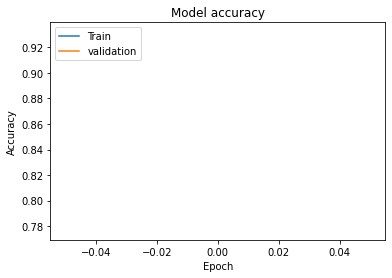

In [8]:
history_df = pd.read_csv(target_dir+'/hystory.csv')
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

## Confusion Matrix

In [9]:
Classes_names =list(validation_generator.class_indices.keys())

In [10]:
validation_generator.reset()
results = model.predict(validation_generator)
results = np.array(results)
predicted_labels_idx = np.argmax(results,axis=1)
predicted_labels_names = np.array([Classes_names[label] for label in predicted_labels_idx])
print(predicted_labels_names.shape)

(11004,)


In [11]:
real_labels_idx = validation_generator.labels
real_labels_names = np.array([Classes_names[label] for label in real_labels_idx])
print(real_labels_names.shape)

(11004,)


In [12]:
print(classification_report(real_labels_names,predicted_labels_names,labels=Classes_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.85      0.92      0.88       126
                                 Apple___Black_rot       0.96      0.87      0.92       125
                          Apple___Cedar_apple_rust       0.91      0.96      0.94        55
                                   Apple___healthy       0.89      0.99      0.94       329
                               Blueberry___healthy       0.99      0.99      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       210
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.75      0.72      0.73       103
                       Corn_(maize)___Common_rust_       1.00      0.91      0.95       239
               Corn_(maize)___Northern_Leaf_Blight       0.80      0.93      0.

In [13]:
conf_matrix = confusion_matrix(real_labels_names,predicted_labels_names,labels=Classes_names,normalize='pred')
conf_matrix_df = pd.DataFrame(conf_matrix, index = Classes_names,columns = Classes_names)

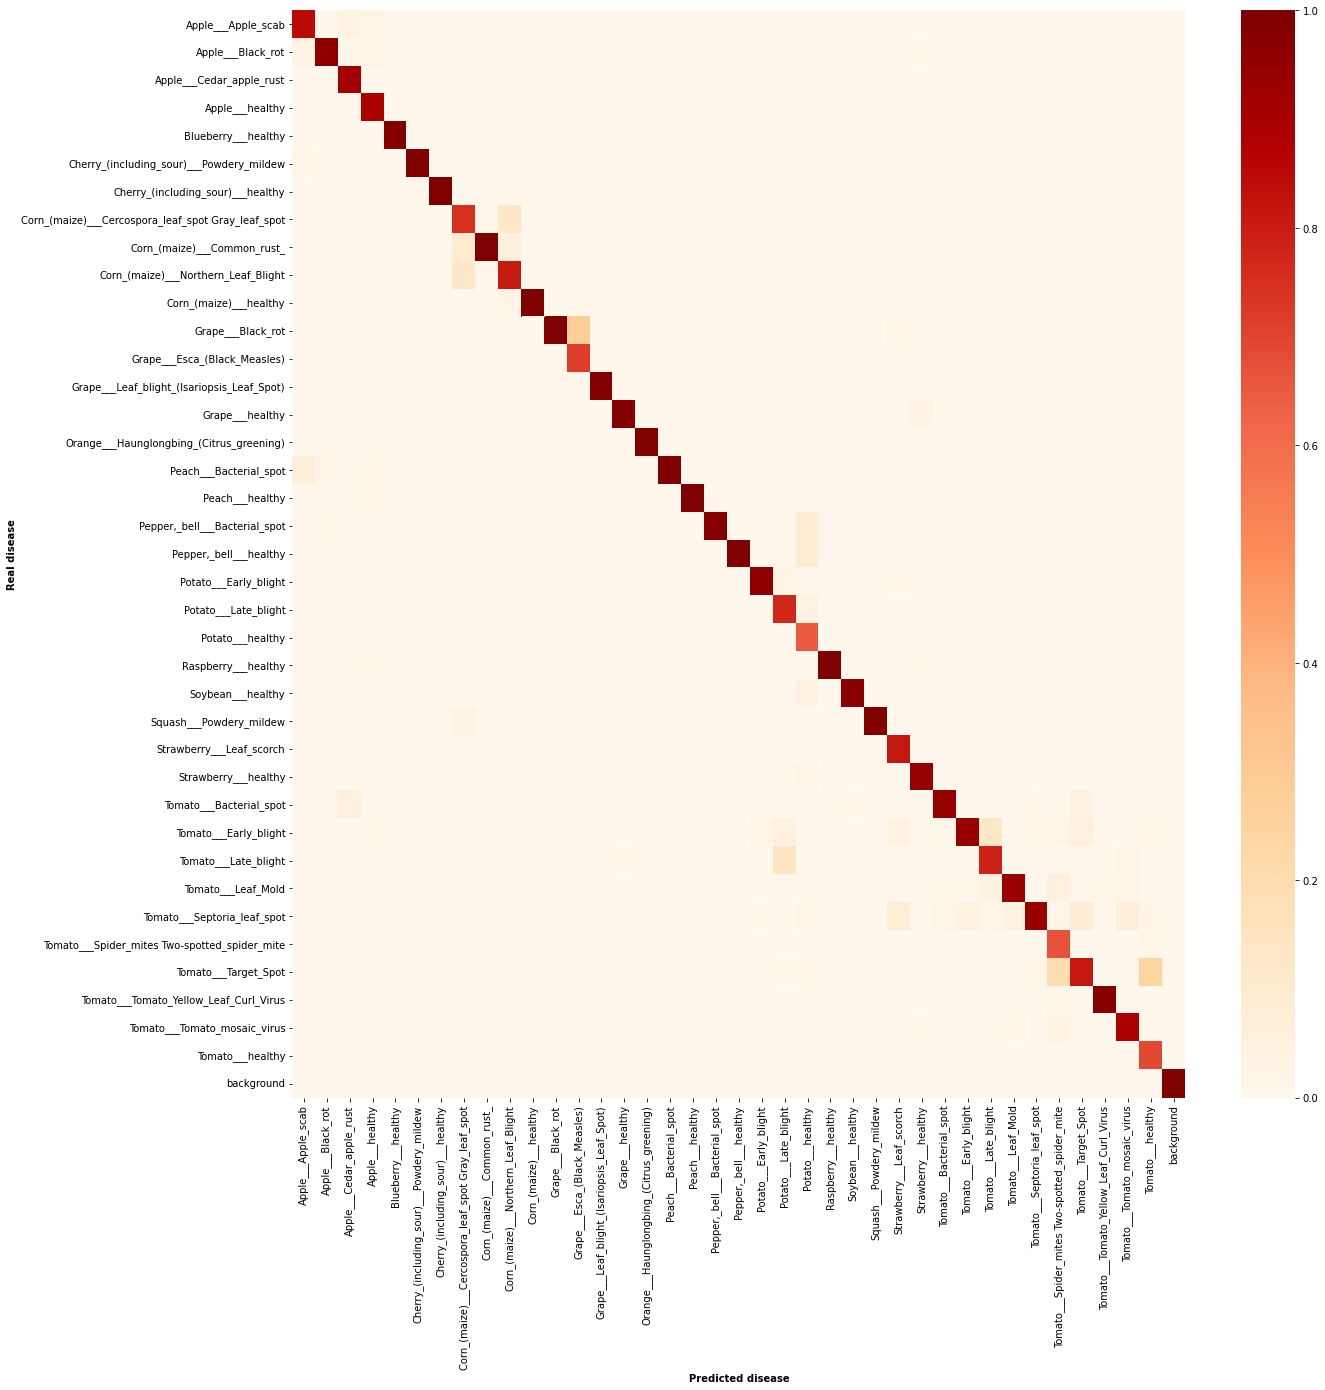

In [14]:
plt.figure(figsize = (20,20))
heatmap = sn.heatmap(conf_matrix_df, annot=False,fmt='.2f',cmap="OrRd",vmin=0, vmax=1)
heatmap.set_xlabel('Predicted disease',fontsize = 10,fontweight="bold")
heatmap.set_ylabel('Real disease',fontsize = 10,fontweight="bold")
heatmap.figure.savefig("Confusion matrix.png")

## Examining the Predictions

In [15]:
def prepare_image_for_prediction(img_path, size = (224,224)):
    # `img` is a PIL image of size 
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = array/255
    return array

def predict_class(image_path):
  image_array = prepare_image_for_prediction(image_path)
  result = model.predict(image_array)
  index_max = result.argmax(axis=1)[0]
  return Classes_names[index_max]

In [17]:
validation_path = '/content/PlantVillage/val'
lists = os.listdir(validation_path)
diseases = []
crops = []
file_lst = []
for folder in lists:
    files = os.listdir(os.path.join(validation_path,folder))
    files = [folder+'/'+file  for file in files]
    file_lst.extend(files)
    if(folder != 'background'): 
      diseases.extend([folder for i in range(len(files))])
      crops.extend([folder.split(sep='___')[0] for i in range(len(files))])
validation_df = pd.DataFrame(list(zip(file_lst,crops,diseases)),columns =["Paths","Crops","Diseases"])

Correct : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


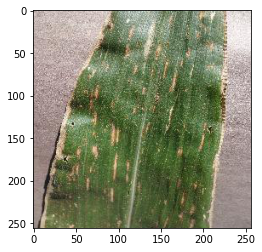

Correct : Orange___Haunglongbing_(Citrus_greening)


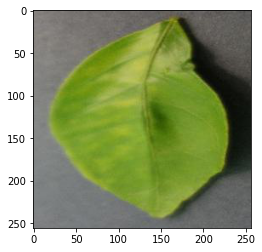

Correct : Tomato___Tomato_Yellow_Leaf_Curl_Virus


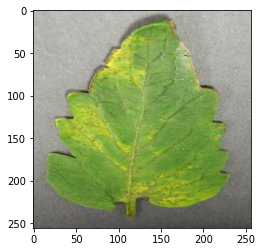

Correct : Corn_(maize)___healthy


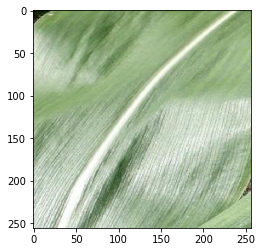

Correct : Tomato___Early_blight


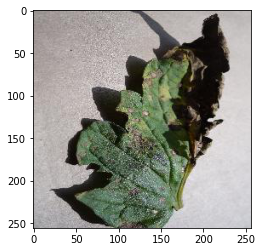

In [18]:
plt.rcParams["axes.grid"] = False
number_images =5
selected_images_df = validation_df.sample(number_images)
for index, row in selected_images_df.iterrows():
  image_path = os.path.join(validation_path,row.Paths)
  real_class = row.Diseases
  predicted_class = predict_class(image_path)
  
  if(real_class == predicted_class):
    print("Correct : " + predict_class(image_path))
  else:
    print("Incorrect : " + real_class + " vs " + predict_class(image_path))

  plt.imshow(Image.open(image_path)) 
  plt.show()  # display it

  

## Examine incorrect classifications




Incorrect : Corn_(maize)___Common_rust_ vs Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


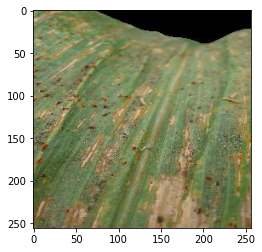

Incorrect : Tomato___Spider_mites Two-spotted_spider_mite vs Tomato___healthy


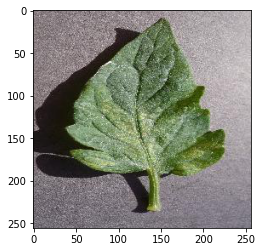

Incorrect : Tomato___Target_Spot vs Tomato___healthy


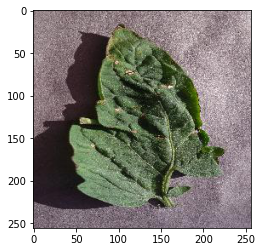

Incorrect : Corn_(maize)___Northern_Leaf_Blight vs Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


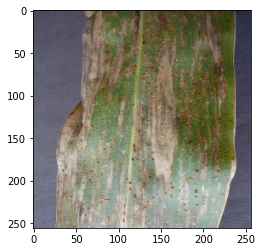

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


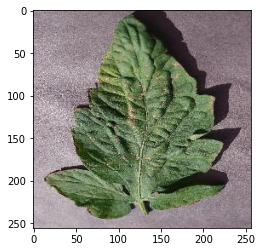

Incorrect : Tomato___Leaf_Mold vs Tomato___Late_blight


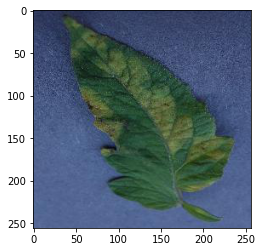

Incorrect : Tomato___Bacterial_spot vs Apple___Apple_scab


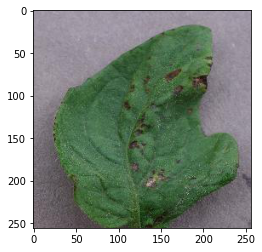

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


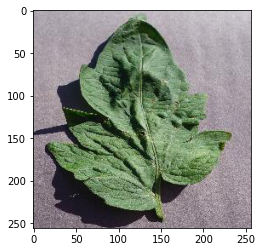

Incorrect : Tomato___Target_Spot vs Tomato___Spider_mites Two-spotted_spider_mite


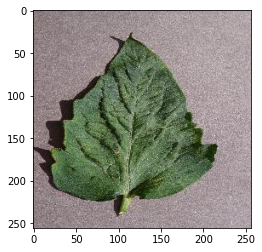

Incorrect : Corn_(maize)___Northern_Leaf_Blight vs Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


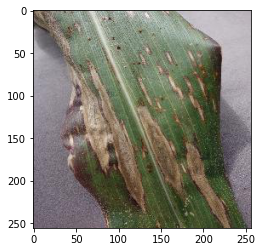

In [19]:
nbr_errors = 10
errors_idxs = np.where(real_labels_names != predicted_labels_names)[0]
errors_paths = np.array(validation_generator.filepaths)[errors_idxs]
errors_sample_paths = random.choices(errors_paths, k=nbr_errors)
plt.rcParams["axes.grid"] = False
for image_path in errors_sample_paths:
  real_class = image_path.split('/')[4]
  predicted_class = predict_class(image_path)

  if(real_class == predicted_class):
    print("Correct : " + predict_class(image_path))
  else:
    print("Incorrect : " + real_class + " vs " + predict_class(image_path))
    
  plt.imshow(Image.open(image_path)) 
  plt.show()  # display it